In [1]:
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import KFold, StratifiedKFold

In [2]:
train = pd.read_csv('train.csv',index_col=0)
test = pd.read_csv('test.csv',index_col=0)

In [3]:
train.columns

Index(['MO HLADR+ MFI (cells/ul)', 'Neu CD64+MFI (cells/ul)',
       'CD3+T (cells/ul)', 'CD8+T (cells/ul)', 'CD4+T (cells/ul)',
       'NK (cells/ul)', 'CD19+ (cells/ul)', 'CD45+ (cells/ul)', 'Age',
       'Sex 0M1F', 'Mono CD64+MFI (cells/ul)', 'label'],
      dtype='object')

In [4]:
for i in range(6):
    for j in range(6):
        if i != j:
            train['gen_{}_{}'.format(i,j)] = train.iloc[:,i]/train.iloc[:,j]
            test['gen_{}_{}'.format(i,j)] = test.iloc[:,i]/test.iloc[:,j]

In [5]:
features = [col for col in train.columns if col != 'label']
num_folds = 10
folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=5001)

In [6]:
# from bayesian optimization
params = {
    'boosting_type': 'gbdt', 
    'objective': 'binary', 
    'metric': 'auc',
    'device_type': 'cpu',
    'random_state': 5001,
    'verbose': -1,
    'learning_rate': 0.0266903682740756,
    'n_estimators': 130,
    'num_leaves': 57,
    'max_depth': -1,
    'subsample': 0.6042971686279393,
    'subsample_freq': 6,
    'colsample_bytree': 0.5656296878622898,
    'reg_lambda': 3.8101081958287514e-05,
    'reg_alpha': 0.0465945527577266,
    'min_child_samples': 2,
    'min_child_weight': 0.06250203857075702,
    }

In [7]:
# 10 fold cv
roc_score = 0
acc = 0
test_preds = []
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train[features], train['label'])):
    train_x, train_y = train[features].iloc[train_idx], train['label'].iloc[train_idx]
    valid_x, valid_y = train[features].iloc[valid_idx], train['label'].iloc[valid_idx]
    
    clf = lgb.LGBMClassifier(**params)
    clf.fit(train_x,train_y)
    pred = clf.predict(valid_x)
    roc_score += roc_auc_score(valid_y, pred)/num_folds
    acc += accuracy_score(valid_y, pred)/num_folds
    test_pred = clf.predict(test[features])
    test_pred = pd.DataFrame({'pred_{}'.format(n_fold): test_pred})
    test_preds.append(test_pred)
print(roc_score)
print(acc)

0.9066666666666666
0.9305555555555554


In [8]:
feat_imp = clf.feature_importances_
# feat_imp

In [9]:
feature_imp = pd.DataFrame(sorted(zip(feat_imp,features))[::-1], columns=['Value','Feature'])

In [10]:
best_feats = []
for idx, row in feature_imp.iterrows():
    feat_name = row['Feature']
    if feat_name.startswith("gen"):
        i = int(feat_name.split("_")[1])
        j = int(feat_name.split("_")[2])
        if (i,j) not in best_feats and (j,i) not in best_feats:
            best_feats.append((i,j))
    if len(best_feats) > 10:
        break
best_feats

[(1, 5),
 (0, 1),
 (2, 1),
 (1, 3),
 (2, 5),
 (0, 2),
 (0, 5),
 (4, 1),
 (5, 4),
 (3, 5),
 (0, 4)]

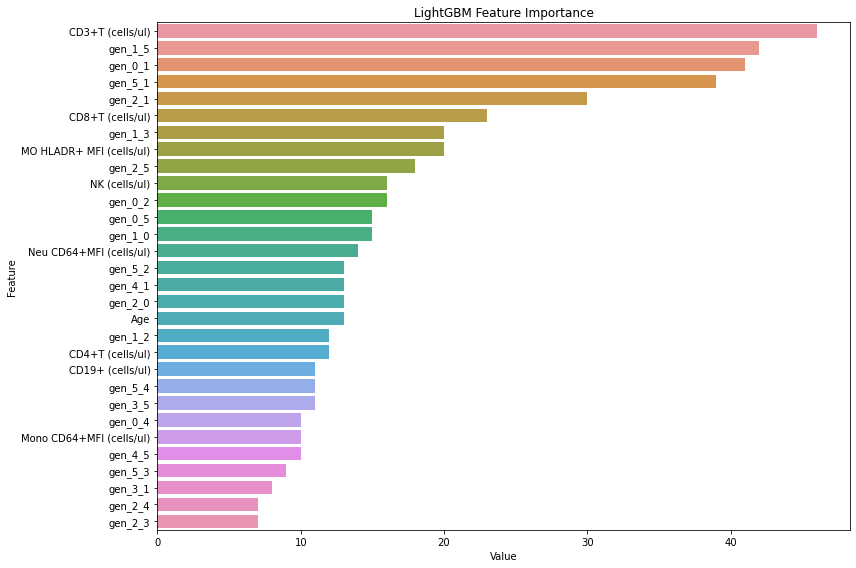

In [11]:
# visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:30,:])
plt.title('LightGBM Feature Importance')
plt.tight_layout()
# plt.savefig('lgbm_importance.png')
plt.show()